==============================SIMULATION CONFIGURATION=================================

= Drag Co-Efficients and Cross Sectional Area

Probe CD (coef.drag)  : 1.0500
Probe S (X section)   : 3.1416 m2
Drogue Chute CDd      : 0.5500
Drogue Chute Sd       : 7.0686 m2
Main Parachute CDp    : 1.7500
Main Parachute Sp     : 56.7450 m2
Balloon CDb           : 0.4700
Balloon Sb            : 38.4845 m2

= Mass

Probe Mass            : 600.00 kg
Payload, Bal./Gas Mass: 125.00 kg
Gas Cylinder Mass     : 150.00 kg
Back Shell Mass       : 50.00 kg
Heat Shield Mass      : 200.00 kg
Drogue Chute Mass     : 25.00 kg
Main Parachute Mass   : 50.00 kg

= Ballistic Entry Characteristics

Entry Angle           : 45.00 degrees
Entry Velocity        : 7816.00 ms
Start Altitude        : 7816.00 maxmetres

= Atmospheric and Planetary

Atmosphere Interface  : 160000.00 m
Scale Height          : 15819.00 m
Gravity (Venus)       : 8.87 ms/s
Equatorial Mean Radius: 6051800.00 ms/s

= Simulation Events

Deploy Dro

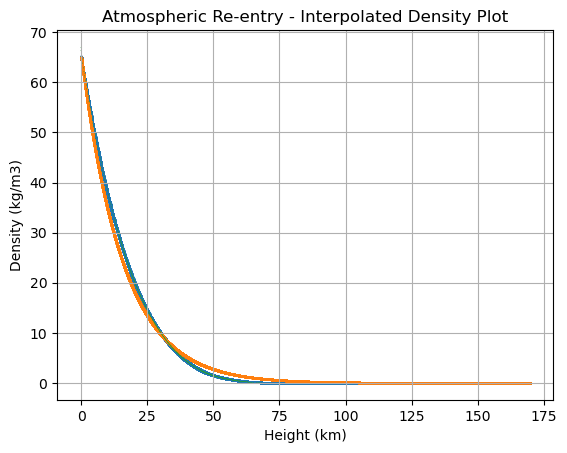

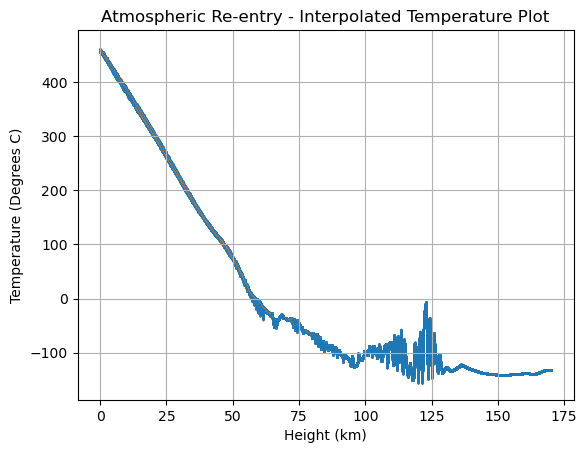

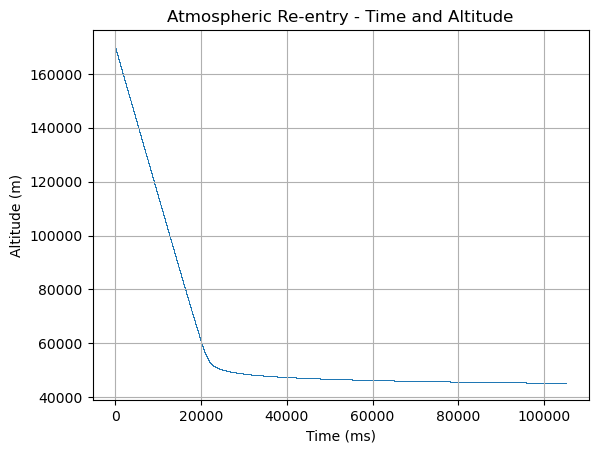

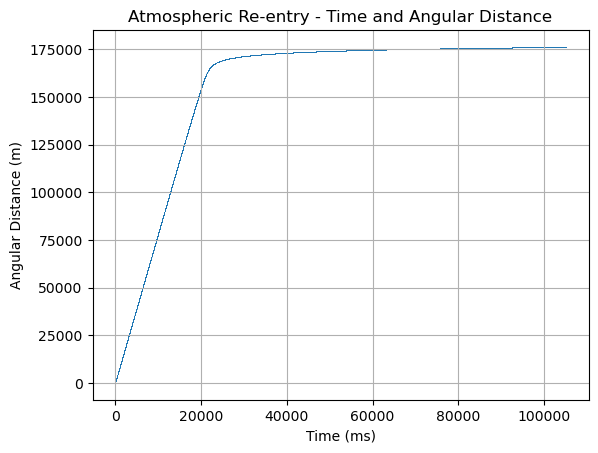

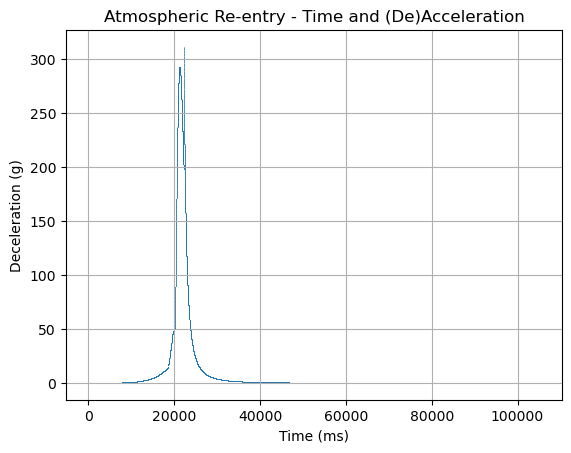

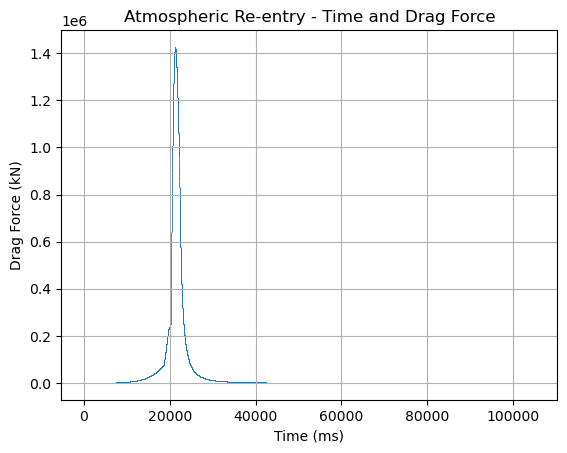

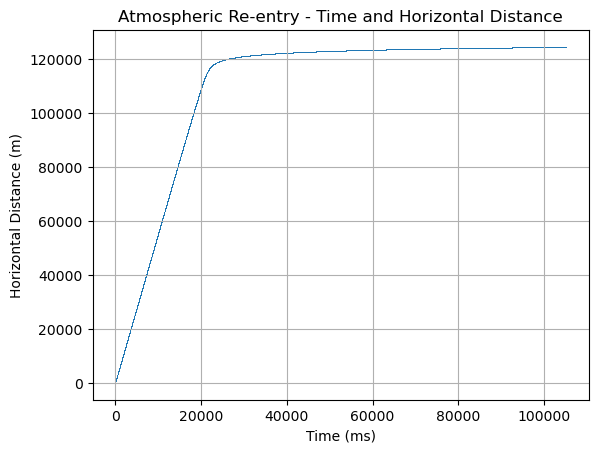

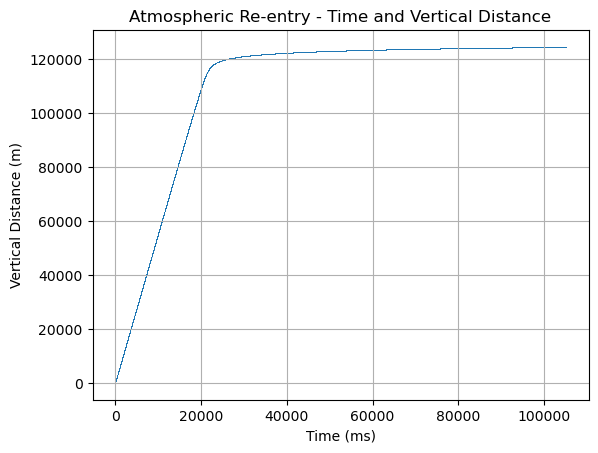

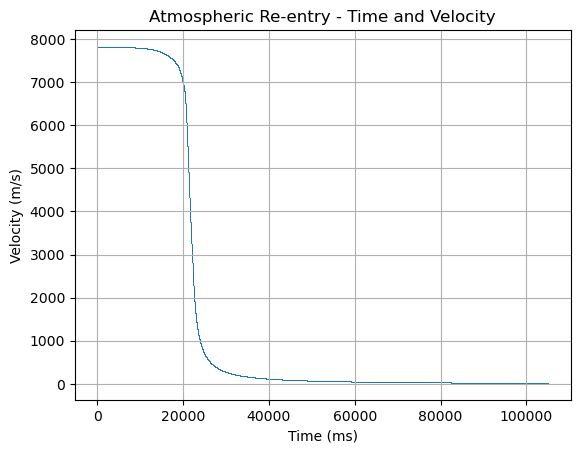

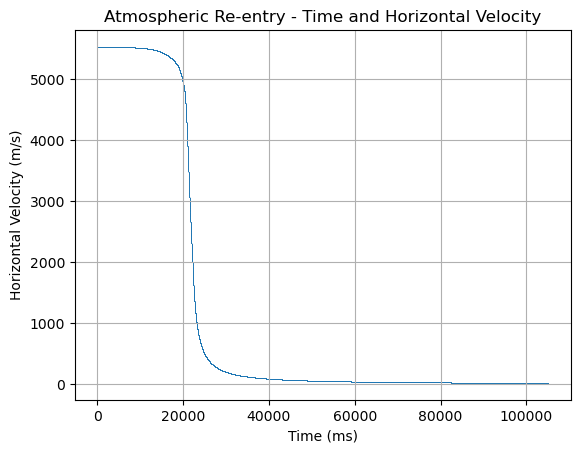

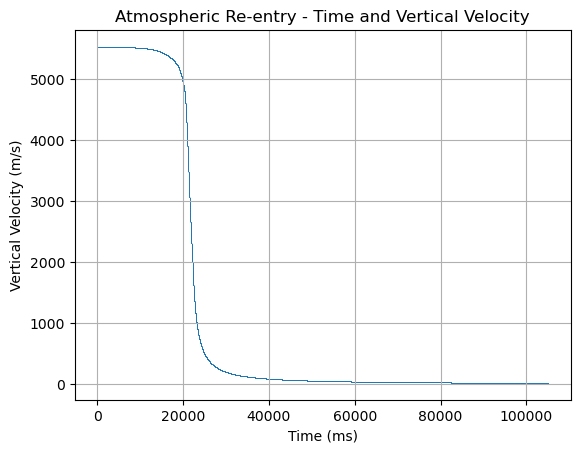

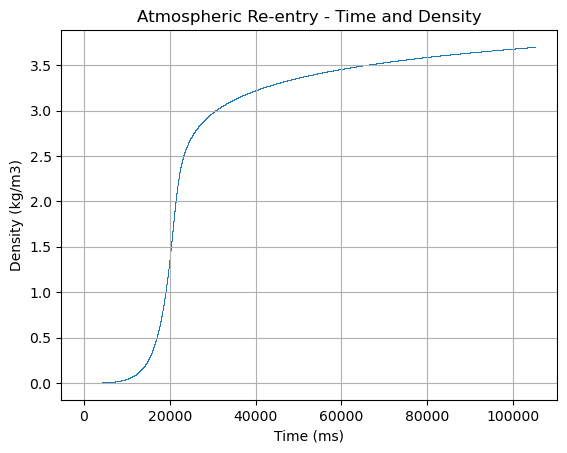

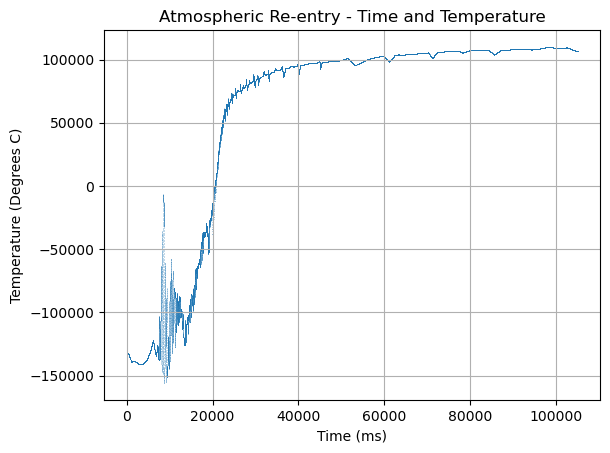


=======================================VALIDATION======================================

Numerical Acc. Peak   : 502.29 m/s/s
Numerical Acc. Peak g : 56.63 g
Numerical Alt Peak Acc: 166971.67 m
Numerical Peak Vel.   : 2875.35 m/s
Numerical Peak Heat R : 704468243.05 W/cm2
Numerical Peak Heat H : 149592.72 m
Numerical Vel. 0-Alt  : 7610.84 m/s


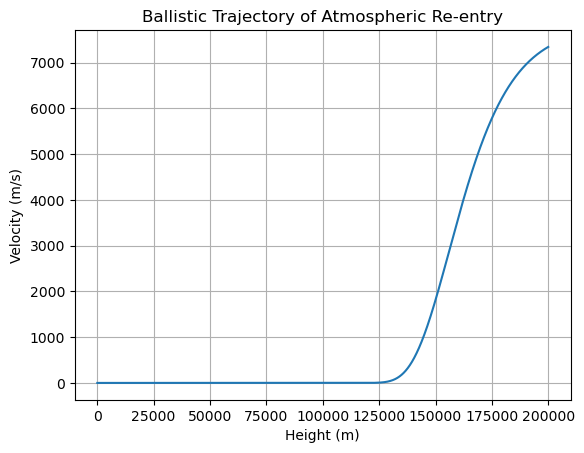

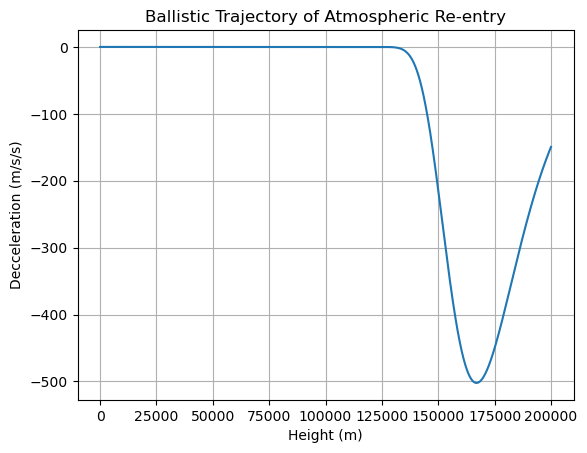

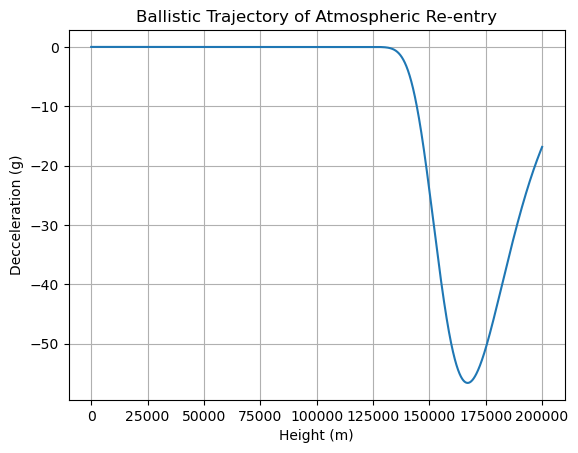


====================================END OF SCRIPT======================================



In [15]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import *
from scipy import interpolate
from scipy.interpolate import interp1d
import datetime

#Ignore deprecated function on data frame append
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

#Use the data created in the atmospheric modelling 
ATM_CSV = r'C:\Users\stuar\OneDrive\Open University\SXS841\Venus Atmospheric Modelling\CSV_Exports\dfALT_D.csv'
ATP_CSV = r'C:\Users\stuar\OneDrive\Open University\SXS841\Venus Atmospheric Modelling\CSV_Exports\dfALT_T.csv'

#Read CSV data into dataframe, on error, print warning and stop kernel.
try:
    dfA=read_csv(ATM_CSV, skiprows=1,names=['ALT-KM','RHO-KG-M3'])
except:
    print("ATM_CSV Venus data does not exist, or some other error")
    Error = True
    exit()

#Read CSV data into dataframe, on error, print warning and stop kernel.
try:
    dfT=read_csv(ATP_CSV, skiprows=1,names=['ALT-KM','T-DEG-K','T-DEG-C'])
except:
    print("ATP_CSV Venus data does not exist, or some other error")
    Error = True
    exit()

#scale and force convert CSV data to float
dfA['ALT-KM'] = dfA['ALT-KM'] * 1000.0
dfA['RHO-KG-M3'] = dfA['RHO-KG-M3'] * 1000.0

dfT['ALT-KM'] = dfT['ALT-KM'] * 1000.0
dfT['T-DEG-K'] = dfT['T-DEG-K'] * 1000.0
dfT['T-DEG-C'] = dfT['T-DEG-C'] * 1000.0

#Sort original data for plotting
dfA.sort_values("ALT-KM", ascending=True)
dfT.sort_values("ALT-KM", ascending=True)

#Model Constants
maxmetres = 170000 # model start altitude, 10km above interface

# Constants - Venus
g    = 8.87    # Venus Gravity m/s^2
R    = 6051800 # equatorial mean radius
RHOs = 65      # Atmospheric density at sea level (kg/m^3)
Hs   = 15819   # atmospheric scale height

#Constants - Vehicle and Probe
Rnose = 1 # 1m radius of nose cone

CD  = 1.05  # Drag coefficient for a blunted cone
CDd = 0.55  # Drag coefficient for a drogue chute
CDs = 0.47  # Drag coefficient for a spherical shape
CDp = 1.75  # Drag coefficient for a typical parachute
CDb = 0.47  # Drag coefficient for a baloon, assume spherical inflation from centre of sphere (simplified)

S  = np.pi*(1.0*1.0)   # Cross-sectional area (m^2) of 2.0m diameter entry capsule (and heat shield)
Sd = np.pi*(1.5*1.5)   # Cross-sectional area (m^2) of 3.0m diameter drogue chute
Sp = np.pi*(4.25*4.25) # Cross-sectional area (m^2) of 8.5m diameter main parachute
Sb = np.pi*(3.5*3.5)   # Cross-sectional area (m^2) of 7.0m diameter balloon

mPayloadAndBalloonAndGas = 125.0
mGasCylinders            = 150.0
mBackShell               = 50.0
mHeatShield              = 200.0
mDrogueChute             = 25.0
mMainParachute           = 50.0

# Initial mass
m  = mPayloadAndBalloonAndGas + mGasCylinders + mBackShell + mHeatShield + mDrogueChute + mMainParachute

#Constants - flight path
y0 = 45         # entry angle in degrees
Ve = 7816       # entry velocity m/s from the orbital speed of 160km circular orbit
h  = 160000     # m atmospheric interface
r  = R + h/1000 # (km)

#Constants - Balloon inflation trigger altitudes
InflateDrogueChuteAlt = 68000 # m
InflateParachuteAlt   = 60000 # m
InflateBalloonAlt     = 48000 # m

#Timing constants for inflation/jettison events
msDrogueChuteInflationTime = 1 # seconds
msParachuteInflationTime   = 2 # seconds
msBalloonInflationTime     = 60 # seconds

#Inflate balloon when the horizontal velocity reaches the predicted windspeed of 60-70 m/s 
#for a lower cloud base altitude (47 km) - from Sánchez-Lavega, A., Hueso, R., Piccioni, G., 
#Drossart, P., Peralta, J., Pérez-Hoyos, S., Wilson, C. F., Taylor, F. W., Baines, K. H., 
#Luz, D., Erard, S., & Lebonnois, S. (2008). Variable winds on Venus mapped in three 
#dimensions. Geophysical Research Letters, 35(13). https://doi.org/10.1029/2008GL033817
HorizontalVelocityMax = 65.0 # m/s

#Maximum number of model step iterations
aMaxMS = 1000000
  
#Set the step resoluton and initial altitude     
StepResolution = 1000.0 # 1000 for milliseconds, 1 for seconds

print("==============================SIMULATION CONFIGURATION=================================")
print("")
print("= Drag Co-Efficients and Cross Sectional Area")
print("")
print("Probe CD (coef.drag)  : " + f'{CD:.4f}' )
print("Probe S (X section)   : " + f'{S:.4f}' + str(' m2'))
print("Drogue Chute CDd      : " + f'{CDd:.4f}' )
print("Drogue Chute Sd       : " + f'{Sd:.4f}' + str(' m2'))
print("Main Parachute CDp    : " + f'{CDp:.4f}' )
print("Main Parachute Sp     : " + f'{Sp:.4f}' + str(' m2'))
print("Balloon CDb           : " + f'{CDb:.4f}' )
print("Balloon Sb            : " + f'{Sb:.4f}' + str(' m2'))
print("")
print("= Mass")
print("")
print("Probe Mass            : " + f'{m:.2f}' + str(' kg'))
print("Payload, Bal./Gas Mass: " + f'{mPayloadAndBalloonAndGas:.2f}' + str(' kg'))
print("Gas Cylinder Mass     : " + f'{mGasCylinders:.2f}' + str(' kg'))
print("Back Shell Mass       : " + f'{mBackShell:.2f}' + str(' kg'))
print("Heat Shield Mass      : " + f'{mHeatShield:.2f}' + str(' kg'))
print("Drogue Chute Mass     : " + f'{mDrogueChute:.2f}' + str(' kg'))
print("Main Parachute Mass   : " + f'{mMainParachute:.2f}' + str(' kg'))
print("")
print("= Ballistic Entry Characteristics")
print("")
print("Entry Angle           : " + f'{y0:.2f}' + str(' degrees'))
print("Entry Velocity        : " + f'{Ve:.2f}' + str(' ms'))
print("Start Altitude        : " + f'{Ve:.2f}' + str(' maxmetres'))
print("")
print("= Atmospheric and Planetary")
print("")
print("Atmosphere Interface  : " + f'{h:.2f}' + str(' m'))
print("Scale Height          : " + f'{Hs:.2f}' + str(' m'))
print("Gravity (Venus)       : " + f'{g:.2f}' + str(' ms/s'))
print("Equatorial Mean Radius: " + f'{R:.2f}' + str(' ms/s'))
print("")
print("= Simulation Events")
print("")
print("Deploy Drogue Altitude: " + f'{InflateDrogueChuteAlt:.2f}' + str(' m'))
print("Deploy Para. Altitude : " + f'{InflateParachuteAlt:.2f}' + str(' m'))
print("Deploy Balloon Alt.   : " + f'{InflateBalloonAlt:.2f}' + str(' m'))
print("Time to Deploy Drogue : " + f'{msDrogueChuteInflationTime:.2f}' + str(' seconds'))
print("Time to Deploy Chute  : " + f'{msParachuteInflationTime:.2f}' + str(' seconds'))
print("Time to Inflate Ball. : " + f'{msBalloonInflationTime:.2f}' + str(' seconds'))
print("Max Vel.Horiz. Ball.  : " + f'{HorizontalVelocityMax:.2f}' + str(' m/s'))
print("Max Simluation Steps  : " + f'{aMaxMS:.2f}' + str(' steps'))
print("Step Resolution       : " + f'{StepResolution:.2f}' + str(' [1000 = ms / 1 = seconds]'))
print("")


#Arrays to hold the atmospheric measurement models of Density and Temperature
densityX = np.linspace(0,maxmetres,maxmetres)
densityY = np.arange(maxmetres,dtype=float)
tempX = np.linspace(0,maxmetres,maxmetres)
tempY = np.arange(maxmetres,dtype=float)
densityY2 = np.arange(maxmetres,dtype=float)

# Function to find the nearest density value in the dataframe
def find_nearest_density(df, AltCol, DenCol, value):
    arrayalt = df[AltCol].values
    arrayrho = df[DenCol].values
    idx = (np.abs(arrayalt - (1.0*value))).argmin()
    return arrayrho[idx]

# Function to find the nearest temperature value in the dataframe
def find_nearest_temp(df, AltCol, TempCol, value):
    arrayalt = df[AltCol].values
    arraydegC = df[TempCol].values
    idx = (np.abs(arrayalt - (1.0*value))).argmin()
    return arraydegC[idx]

# Create a 1m density height model from measurements
for AltCount in range(maxmetres):
    nearest_density = find_nearest_density(dfA, 'ALT-KM', 'RHO-KG-M3',AltCount)
    densityY[AltCount] = nearest_density

# Create a 1m temperature height model from measurements
for AltCount in range(maxmetres):
    nearest_temp = find_nearest_temp(dfT, 'ALT-KM', 'T-DEG-C',AltCount)
    tempY[AltCount] = nearest_temp
    
#From mathematical means, create an atmosphere model for validation purposes
for AltCount in range(maxmetres):
      #ρ = ρ0 exp ( -h / H )
      densityY2[AltCount] = RHOs * np.exp(-(AltCount/Hs))

    
# Interpolate the 'step' changes to increase fidelity to 1m steps    
Y1 = densityY[0]
Y2 = 0.0
X1 = 0
X2 = 0

#For each metre of height, smooth (simple interpolation)
for AltCount in range(maxmetres):
    if Y1 != densityY[AltCount]:
        #A step change has been detected
        X2 = AltCount - 1
        Y2 = densityY[AltCount]

        #Calculate the scaling factor to apply (interpolate)
        Yfactor = (Y2-Y1)/(X2-X1+1)
        
        #Now interpolate between the 2 points
        for InterpCount in range(X2-X1+1):
            densityY[int(X1+InterpCount)] = Y1 + (Yfactor*InterpCount)
        
        #Start a new step 
        Y1 = densityY[AltCount]
        X1 = AltCount

# Interpolate the 'step' changes to increase fidelity to 1m steps    
Y1 = tempY[0]
Y2 = 0.0
X1 = 0
X2 = 0

#For each metre of height, smooth (simple interpolation so each metre of height has a value)
for AltCount in range(maxmetres):
    if Y1 != tempY[AltCount]:
        #A step change has been detected
        X2 = AltCount - 1
        Y2 = tempY[AltCount]

        #Calculate the scaling factor to apply (interpolate)
        Yfactor = (Y2-Y1)/(X2-X1+1)
        
        #Now interpolate between the 2 points
        for InterpCount in range(X2-X1+1):
            tempY[int(X1+InterpCount)] = Y1 + (Yfactor*InterpCount)
        
        #Start a new step 
        Y1 = tempY[AltCount]
        X1 = AltCount        

#Set the 1st step conditions
Alt = maxmetres
Vcurrent = Ve
aStep = 0.0
Acc = 0.0
Drag = 0.0
AngleD = 0.0
VerticalD = 0.0
VerticalDstep = 0.0
HorizontalD = 0.0
VerticalV = 0.0
HorizontalV = 0.0
RHOmd = 0.0
Tempmd = 0.0

#Set the flags
DrogueChuteDeployed = False
DrogueChuteInflated = False
ParachuteDeployed = False
ParachuteInflated = False
BalloonDeployed = False
BalloonInflated = False
GravityDominant = False
DragisZero = False
GravGreaterThanDrag = False

#Convert entry angle to radians
gammaR = np.radians(y0)

#Step model data frame
dfStepModel = DataFrame(columns=['TimeMS','Alt','Acc','Drag','Velocity','VerticalV','HorizontalV','HorizontalD', 'VerticalD', 'AngleD', 'Density', 'Temperature'])

#Atmospheric Model or Measurement Basis
UseMeasurements = False

#Peak Values and Time Markers
PeakAcc = 0.0
PeakAccTimeStep = 0.0
PeakTemp = 0.0
PeakTempTimeStep = 0.0
PeakDensity = 0.0
PeakDensityTimeStep = 0.0
LowestAltitude = Alt
LowestAltitudeTimeStep = 0.0

print("==================================SIMULATION START=====================================")
StartTimeDate = datetime.datetime.now()

#Create the step model
for msCount in range(aMaxMS):

    #Exit if we hit the ground !
    if Alt <= 0:
        print(f'{msCount/StepResolution:08.3f}'+ ' Hit ground, model stopping')        
        Alt = 0
        break;
        
    #Exit if velocities go below ZERO past the atmospheric interface
    if Vcurrent <= 0 and Alt <= h:
        #Velocity along flight path has been 'scrubbed' to zero by the drag forces, now the balloon 
        #if inflated will start to rise, and the vertical and horizontal velocities will only be impacted
        #by lift forces and wind speed 
        print(f'{msCount/StepResolution:08.3f}'+ ' Negative Velocity Vcurrent')
        print(f'{msCount/StepResolution:08.3f}'+ ' Velocity Vcurrent: ' + str(Vcurrent))
        print(f'{msCount/StepResolution:08.3f}'+ ' Velocity Vvert: ' + str(VerticalV))
        print(f'{msCount/StepResolution:08.3f}'+ ' Velocity Vhoriz: ' + str(HorizonatalV))
        Alt = 0
        break;
    if VerticalV <= 0 and Alt <= h:
        print(f'{msCount/StepResolution:08.3f}'+ ' Negative Velocity Vvert')
        print(f'{msCount/StepResolution:08.3f}'+ ' Velocity Vcurrent: ' + str(Vcurrent))
        print(f'{msCount/StepResolution:08.3f}'+ ' Velocity Vvert: ' + str(VerticalV))
        print(f'{msCount/StepResolution:08.3f}'+ ' Velocity Vhoriz: ' + str(HorizonatalV))
        Alt = 0
        break;
    if HorizontalV <= 0 and Alt <= h:
        print(f'{msCount/StepResolution:08.3f}'+ ' Negative Velocity Vhoriz')
        print(f'{msCount/StepResolution:08.3f}'+ ' Velocity Vcurrent: ' + str(Vcurrent))
        print(f'{msCount/StepResolution:08.3f}'+ ' Velocity Vvert: ' + str(VerticalV))
        print(f'{msCount/StepResolution:08.3f}'+ ' Velocity Vhoriz: ' + str(HorizonatalV))
        Alt = 0
        break;

    #calculate the velocity and displacement in the horizontal and vertical at end of step  
    AngleD = AngleD + (Vcurrent / StepResolution)
    VerticalDstep = abs((np.sin(gammaR) * (Vcurrent / StepResolution)))
    VerticalD = VerticalD + abs((np.sin(gammaR) * (Vcurrent / StepResolution)))
    HorizontalD = HorizontalD + (np.cos(gammaR) * (Vcurrent / StepResolution))
    VerticalV = np.abs(np.sin(gammaR) * Vcurrent)
    HorizontalV = np.abs(np.cos(gammaR) * Vcurrent)
    
    #Get the density of air for this altitude using measurements or calculate from equation         
    if UseMeasurements == True:
        RHOmd = densityY[int(Alt)-1]
    else:
        RHOmd = densityY2[int(Alt)-1]
        
    #Get the temperature for this altitude
    Tempmd = tempY[int(Alt)-1]
        
    #Calulate the drag force of the main probe (without drogue or main chute) - assume constant CD and S 
    #even with jettison of backshell, heatshield and cynlinders - simplification
    Drag = 0.5 * RHOmd * ((Vcurrent)*(Vcurrent)) * CD * S

    #Adjust co-efficients, mass and cross-sectional areas for deployment events
    if Alt < InflateBalloonAlt and HorizontalV < HorizontalVelocityMax:
        if BalloonDeployed == False:
            print(f'{msCount/StepResolution:08.3f}'+ ' Balloon inflating')            
            print(f'{msCount/StepResolution:08.3f}'+ ' Mass change, mass now: ' + str(m) + str(' kg'))
            BalloonDeployed = True
            InflationStartTime = msCount
            SFactor = Sb / (msBalloonInflationTime * StepResolution)
            lclSb = 0.0001 #small, but not ZERO

        if msCount < (InflationStartTime + (msBalloonInflationTime * StepResolution)):
            #increasing cross sectional area as it inflates over the msBalloonInflationTime steps
            lclSb = lclSb + SFactor
        else:
            if BalloonInflated == False:
                #Reduce mass by jettisoning the parachutes and the main gas cylinders
                m = m - mDrogueChute - mMainParachute - mGasCylinders 
                print(f'{msCount/StepResolution:08.3f}'+ ' Chutes and cylinders released')            
                print(f'{msCount/StepResolution:08.3f}'+ ' Mass change, mass now: ' + str(m) + str(' kg'))
                print(f'{msCount/StepResolution:08.3f}'+ ' Balloon inflated')                            
                #Remove drag effects of the chutes
                DragParachute = 0.0
                DragDrogue = 0.0
                BalloonInflated = True
                lclSb = Sb
                #Stop Simulation
                break;
                #Need to add lifting force into the mix
            
        #Add additional drag for the balloon on top of main parachute and the drogue
        DragBalloon = 0.5 * RHOmd * ((Vcurrent)*(Vcurrent)) * CDb * lclSb
        DragParachute = 0.5 * RHOmd * ((Vcurrent)*(Vcurrent)) * CDp * Sp
        DragDrogue = 0.5 * RHOmd * ((Vcurrent)*(Vcurrent)) * CDd * Sd
        Drag = Drag + DragDrogue + DragParachute + DragBalloon
                
    elif Alt < InflateParachuteAlt:
        if ParachuteDeployed == False:
            print(f'{msCount/StepResolution:08.3f}'+ ' Main Parachue deployed')            
            ParachuteDeployed = True
            InflationStartTime = msCount
            SFactor = Sp / (msParachuteInflationTime * StepResolution)
            lclSp = 0.0001 #small, but not ZERO
        
        if msCount < (InflationStartTime + (msParachuteInflationTime * StepResolution)):
            #increasing cross sectional area as it inflates over the msParachuteInflationTime steps
            lclSp = lclSp + SFactor
        else:
            if ParachuteInflated == False:
                ParachuteInflated = True
                #Reduce mass by jettisoning the heat shield
                m = m - mHeatShield 
                print(f'{msCount/StepResolution:08.3f}'+ ' Heat Shield released')            
                print(f'{msCount/StepResolution:08.3f}'+ ' Mass change, mass now: ' + str(m) + str(' kg'))
                print(f'{msCount/StepResolution:08.3f}'+ ' Main Parachute inflated')            
                lclSd = Sp
            
        #Add additional drag for the main parachute on top of the drogue
        DragParachute = 0.5 * RHOmd * ((Vcurrent)*(Vcurrent)) * CDp * lclSp
        DragDrogue = 0.5 * RHOmd * ((Vcurrent)*(Vcurrent)) * CDd * Sd
        Drag = Drag + DragDrogue + DragParachute 

    #Adjust for drogue chute
    elif Alt < InflateDrogueChuteAlt:
        if DrogueChuteDeployed == False:
            #Reduce mass by jettisoning the backshell covering the drogue chute
            m = m - mBackShell
            print(f'{msCount/StepResolution:08.3f}'+ ' Back Shell released')            
            print(f'{msCount/StepResolution:08.3f}'+ ' Mass change, mass now: ' + str(m) + str(' kg'))
            print(f'{msCount/StepResolution:08.3f}'+ ' Drogue Chute deployed')            
            DrogueChuteDeployed = True
            InflationStartTime = msCount
            SFactor = Sd / (msDrogueChuteInflationTime * StepResolution)
            lclSd = 0.0001 #small, but not ZERO
        
        if msCount < (InflationStartTime + (msDrogueChuteInflationTime * StepResolution)):
            #increasing cross sectional area over the msDrogueChuteInflationTime steps
            lclSd = lclSd + SFactor
        else:
            if DrogueChuteInflated == False:
                DrogueChuteInflated = True
                print(f'{msCount/StepResolution:08.3f}'+ ' Drogue Chute inflated')                            
                lclSd = Sd
           
        #Add additional drag for the drogue chute
        DragDrogue = 0.5 * RHOmd * ((Vcurrent)*(Vcurrent)) * CDd * lclSd
        Drag = Drag + DragDrogue
    
    #Calculate gravitational force (at angle) acting on the trajectory velocity along path of entry
    GravForce = m * (g / np.sin(gammaR))
    
    if GravForce > Drag and Alt < 40000:
        #Gravity becoming dominant 
        if GravityDominant == False:
            GravityDominant = True
            print(f'{msCount/StepResolution:08.3f}'+ ' Gravity dominant force')
    
    #Calculate the deceleration (F = ma) adjusting drag for gravity along the path of entry 
    if Drag < GravForce or Drag < 0.0:
           
        if Drag < 0.0:
            #Drag should not be negative in this model until exited the entry flight path and in 'ascension'
            if DragisZero == False:
                DragisZero = True;
                print(f'{msCount/StepResolution:08.3f}'+ ' Drag negative, Gravity Force: ' + f'{GravForce:.2f}' + ' N')
            Acc = GravForce / m
        else:
            if GravGreaterThanDrag == False and Alt < InflateDrogueChuteAlt:
                GravGreaterThanDrag = True
                print(f'{msCount/StepResolution:08.3f}'+ ' Gravity > Drag')
                print(f'{msCount/StepResolution:08.3f}'+ ' Drag Force: ' + f'{Drag:.2f}' + ' N')
                print(f'{msCount/StepResolution:08.3f}'+ ' Gravity Force: ' + f'{GravForce:.2f}' + ' N')
            Acc = (GravForce - Drag) / m
    else:
        #Acceleration adjusted for effect of gravity 
        Acc = (Drag - GravForce) / m

    #Calculate the exit altitude
    Alt = Alt - VerticalDstep
    
    #Calculate the exit velocity along the path of entry of this step, decceleration acts over 1m-ms/1m-ms
    Vcurrent = Vcurrent - abs(Acc / StepResolution / StepResolution)
    
    #Store the step output states
    stepData = {'TimeMS':msCount,
                'Alt' : Alt,
                'Acc' : Acc,
                'Drag' : Drag,
                'Velocity' : Vcurrent,
                'VerticalV' : VerticalV,
                'HorizontalV' : HorizontalV,
                'HorizontalD' : HorizontalD,
                'VerticalD' : VerticalD,
                'AngleD' : AngleD,
                'Density' : RHOmd,
                'Temperature' : Tempmd}
    dfStepModel = dfStepModel.append(stepData, ignore_index=True)

    #Store peak values and timestamps
    if PeakAcc < Acc:
        PeakAcc = Acc
        PeakAccTimeStep = msCount

    if PeakTemp < Tempmd:
        PeakTemp = Tempmd
        PeakTempTimeStep = msCount
        
    if PeakDensity < RHOmd:
        PeakDensity = RHOmd
        PeakDensityTimeStep = msCount

    if LowestAltitude > Alt:
        LowestAltitude = Alt
        LowestAltitudeTimeStep = msCount
    
    #Comfort Message whilst processing (10 seconds)
    if msCount % (10 * StepResolution) == 0:
        print(f'{msCount/StepResolution:08.3f}'+ ' Reached altitude of ' + f'{Alt/1000:.2f}' + ' km')

    #End of Loop
    
#Mark end of simulation
EndTimeDate = datetime.datetime.now()
TimeDifference = EndTimeDate - StartTimeDate
RunTimeSeconds = TimeDifference.total_seconds()

#Print summary
print("")
print("==================================SIMULATION ENDED=====================================")
print("")

print("====================================SUMMARY DATA=======================================")
print("Start Time (real)     : " + str(StartTimeDate))
print("End Time (real)       : " + str(EndTimeDate))
print("Run Time (real)       : " + str(RunTimeSeconds) + str(' seconds'))
print("Run Time (sim)        : " + f'{msCount/StepResolution:.2f}' + str(' seconds'))
print("Velocity              : " + f'{Vcurrent:.2f}' + str(' m/s'))
print("Acceleration          : " + f'{Acc / StepResolution / StepResolution:.2f}' + str(' m/s/s'))
print("Vertical Velocity     : " + f'{VerticalV:.2f}' + str(' m/s'))
print("Horizontal Velocity   : " + f'{HorizontalV:.2f}' + str(' m/s'))
print("Vertical Distance     : " + f'{VerticalD / 1000.0:.2f}' + str(' km'))
print("Horizontal Distance   : " + f'{HorizontalD / 1000.0:.2f}' + str(' km'))
print("Max Deceleration      : " + f'{PeakAcc / g / StepResolution:.2f}' + str(' g'))
print("Max Deceleration Time : " + f'{PeakAccTimeStep/StepResolution:.2f}' + str(' seconds'))
print("Max Temperature       : " + f'{PeakTemp:.2f}' + str(' Degrees C'))
print("Max Temperature Time  : " + f'{PeakTempTimeStep/StepResolution:.2f}' + str(' seconds'))
print("Max Density           : " + f'{PeakDensity:.4f}' + str(' kg/m3'))
print("Max Density Time      : " + f'{PeakDensityTimeStep/StepResolution:.2f}' + str(' seconds'))
print("Lowest Altitude       : " + f'{LowestAltitude / 1000.0:.2f}' + str(' km'))
print("Lowest Altitude Time  : " + f'{LowestAltitudeTimeStep/StepResolution:.2f}' + str(' seconds'))
print("=======================================================================================")

print("")
print("=========================================PLOTS=========================================")
print("")    
    
#Re-scale for plotting    
densityX = densityX / 1000.0
densityY = densityY / 1000.0
tempX = tempX / 1000.0
tempY = tempY / 1000.0

dfA['ALT-KM'] = dfA['ALT-KM'] / 1000.0
dfA['RHO-KG-M3'] = dfA['RHO-KG-M3'] / 1000.0

dfT['ALT-KM'] = dfT['ALT-KM'] / 1000.0
dfT['T-DEG-C'] = dfT['T-DEG-C'] / 1000.0

#Sort original data for plotting
dfA.sort_values("ALT-KM", ascending=True)
dfT.sort_values("ALT-KM", ascending=True)

#Plot the density model
plt.scatter(densityX, densityY, s=0.1)
plt.scatter(densityX, densityY2, s=0.1)
plt.scatter(dfA['ALT-KM'],dfA['RHO-KG-M3'], s=0.1, linewidth=0)
plt.title('Atmospheric Re-entry - Interpolated Density Plot')
plt.xlabel('Height (km)')
plt.ylabel('Density (kg/m3)')
plt.grid(True)
plt.show()

#Plot the temp model
plt.scatter(tempX, tempY, s=0.1)
plt.scatter(dfT['ALT-KM'],dfT['T-DEG-C'], s=0.1, linewidth=0)
plt.title('Atmospheric Re-entry - Interpolated Temperature Plot')
plt.xlabel('Height (km)')
plt.ylabel('Temperature (Degrees C)')
plt.grid(True)
plt.show()

#Plot the step model
plt.scatter(dfStepModel['TimeMS'],dfStepModel['Alt'], s=0.1, linewidth=0)
plt.title('Atmospheric Re-entry - Time and Altitude')
plt.xlabel('Time (ms)')
plt.ylabel('Altitude (m)')
plt.grid(True)
plt.show()

plt.scatter(dfStepModel['TimeMS'],dfStepModel['AngleD'], s=0.1, linewidth=0)
plt.title('Atmospheric Re-entry - Time and Angular Distance')
plt.xlabel('Time (ms)')
plt.ylabel('Angular Distance (m)')
plt.grid(True)
plt.show()

dfStepModel['Acc'] = dfStepModel['Acc'] / g / StepResolution
plt.scatter(dfStepModel['TimeMS'],dfStepModel['Acc'], s=0.2, linewidth=0)
plt.title('Atmospheric Re-entry - Time and (De)Acceleration')
plt.xlabel('Time (ms)')
plt.ylabel('Deceleration (g)')
plt.grid(True)
plt.show()

dfStepModel['Drag'] = dfStepModel['Drag'] / 1000.0
plt.scatter(dfStepModel['TimeMS'],dfStepModel['Drag'], s=0.2, linewidth=0)
plt.title('Atmospheric Re-entry - Time and Drag Force')
plt.xlabel('Time (ms)')
plt.ylabel('Drag Force (kN)')
plt.grid(True)
plt.show()

plt.scatter(dfStepModel['TimeMS'],dfStepModel['HorizontalD'], s=0.1, linewidth=0)
plt.title('Atmospheric Re-entry - Time and Horizontal Distance')
plt.xlabel('Time (ms)')
plt.ylabel('Horizontal Distance (m)')
plt.grid(True)
plt.show()

plt.scatter(dfStepModel['TimeMS'],dfStepModel['VerticalD'], s=0.1, linewidth=0)
plt.title('Atmospheric Re-entry - Time and Vertical Distance')
plt.xlabel('Time (ms)')
plt.ylabel('Vertical Distance (m)')
plt.grid(True)
plt.show()

plt.scatter(dfStepModel['TimeMS'],dfStepModel['Velocity'], s=0.1, linewidth=0)
plt.title('Atmospheric Re-entry - Time and Velocity')
plt.xlabel('Time (ms)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)
plt.show()

plt.scatter(dfStepModel['TimeMS'],dfStepModel['HorizontalV'], s=0.1, linewidth=0)
plt.title('Atmospheric Re-entry - Time and Horizontal Velocity')
plt.xlabel('Time (ms)')
plt.ylabel('Horizontal Velocity (m/s)')
plt.grid(True)
plt.show()

plt.scatter(dfStepModel['TimeMS'],dfStepModel['VerticalV'], s=0.1, linewidth=0)
plt.title('Atmospheric Re-entry - Time and Vertical Velocity')
plt.xlabel('Time (ms)')
plt.ylabel('Vertical Velocity (m/s)')
plt.grid(True)
plt.show()

plt.scatter(dfStepModel['TimeMS'],dfStepModel['Density'], s=0.1, linewidth=0)
plt.title('Atmospheric Re-entry - Time and Density')
plt.xlabel('Time (ms)')
plt.ylabel('Density (kg/m3)')
plt.grid(True)
plt.show()

plt.scatter(dfStepModel['TimeMS'],dfStepModel['Temperature'], s=0.1, linewidth=0)
plt.title('Atmospheric Re-entry - Time and Temperature')
plt.xlabel('Time (ms)')
plt.ylabel('Temperature (Degrees C)')
plt.grid(True)
plt.show()


#store the model
tempfilesdirectory = r'C:\Users\stuar\OneDrive\Open University\SXS841\Venus Entry Modelling'
EntryStepModel = tempfilesdirectory + r'\entrystepmodel.csv'
dfStepModel.to_csv(EntryStepModel, index=False)


print("")
print("=======================================VALIDATION======================================")
print("")   

#Numerical Calculations (for validation of ballistic entry elements of the model only)
#invalid beyond drogue chute deployment.

#Adjust the constants
Beta = 1/Hs 
BC = m/(CD*S)

#Convert entry angle to radians (angle needs to be negative for numerical analysis)
gammaR = np.radians(-y0)

#Create a linear atmosphere in 1 m steps
atmosphere = np.linspace(0,200000,200000)

#Calculate velocity as a function of altitude
Va1 = Ve*np.exp((1/(2*Beta))*(RHOs/np.sin(gammaR))*((S*CD)/m)*np.exp(-Beta*atmosphere))

#https://ntrs.nasa.gov/api/citations/19930091020/downloads/19930091020.pdf
bnl = np.exp(1)
Top = RHOs * Hs
Bottom = 2*BC*np.sin(np.abs(gammaR))
Component1 = Top / Bottom
Component2 = np.power(bnl, ((-atmosphere)/Hs)-(np.power(bnl,(-h)/Hs)))
Component3 = Component1 * Component2 * -1
Va = Ve*np.exp(Component3)
               
drdt = Va1*np.sin(gammaR)
dhdt = drdt
dVdh = (Va1[0:-2]-Va1[1:-1])/(atmosphere[0:-2]-atmosphere[1:-1])
acccelA = dVdh*dhdt[0:-2]

# Max Acceleration
amax = -((Beta*Ve*Ve)/(2*np.exp(1))*np.sin(gammaR))
print("Numerical Acc. Peak   : " + f'{amax:.2f}' + ' m/s/s')
print("Numerical Acc. Peak g : " + f'{amax / g:.2f}' + ' g')

#Altitude of Max Decceleration
hcrit = (1/Beta)*(np.log((-1/Beta)*(S*CD/m)*(RHOs/np.sin(gammaR))))
print("Numerical Alt Peak Acc: " + f'{hcrit:.2f}' + ' m')

#Velocity of Max Deceleration
Vcrit = Ve/np.e
print("Numerical Peak Vel.   : " + f'{Vcrit:.2f}' + ' m/s')

#Heating Rate
Qdot = (1.83/10000)*(Ve*Ve*Ve)*np.sqrt(RHOs/Rnose)
print("Numerical Peak Heat R : " + f'{Qdot:.2f}' + ' W/cm2')

#Altitude Max Heating Rate
#Value = RHOs/(3*BC*Beta*np.sin(gammaR))
hqmax = (1/Beta)*np.log(np.abs(RHOs/(3*BC*Beta*np.sin(gammaR))))
print("Numerical Peak Heat H : " + f'{hqmax:.2f}' + ' m')

#https://ntrs.nasa.gov/api/citations/19930091020/downloads/19930091020.pdf
#Impact velocity?
Vo = Ve*np.power(bnl,(-1*((CD*RHOs*S)/(2*BC*m*np.sin(np.abs(y0))))))
print("Numerical Vel. 0-Alt  : " + f'{Vo:.2f}' + ' m/s')
         
# Plot trajectory
plt.plot(atmosphere, Va)
plt.title('Ballistic Trajectory of Atmospheric Re-entry')
plt.xlabel('Height (m)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)
plt.show()

plt.plot(atmosphere[0:-2], acccelA)
plt.title('Ballistic Trajectory of Atmospheric Re-entry')
plt.xlabel('Height (m)')
plt.ylabel('Decceleration (m/s/s)')
plt.grid(True)
plt.show()

plt.plot(atmosphere[0:-2], acccelA/g)
plt.title('Ballistic Trajectory of Atmospheric Re-entry')
plt.xlabel('Height (m)')
plt.ylabel('Decceleration (g)')
plt.grid(True)
plt.show()

print("")
print("====================================END OF SCRIPT======================================")
print("")   

